# 1.Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from transformers import AutoModel, AutoTokenizer, TFAutoModel
import torch
from tensorflow.keras import layers, models
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import jieba

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        pass

# 2.Data

In [3]:
# 加载数据集    Загрузка набора данных
file_path = r"C:\Users\lcf14\Desktop\homework\Machine_Learning_appli\ecommerceDataset.csv\ecommerceDataset.csv"
data = pd.read_csv(file_path)

# 随机抽样 100 条数据    Случайная выборка 100 строк данных
#data = data.sample(n=100, random_state=42)

In [4]:
# 查看数据格式    Просмотр формата данных
print(data.head())

   Household  \
0  Household   
1  Household   
2  Household   
3  Household   
4  Household   

  Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your 

In [5]:
# 提取标签和文本    Извлечение меток и текстов
labels = data.iloc[:, 0]  # 提取数据集的第一列作为标签    Извлечение первого столбца набора данных в качестве меток
texts = data.iloc[:, 1]  # 提取数据集的第二列作为文本    Извлечение второго столбца набора данных в качестве текстов

# 确保文本是字符串组成的列表    Убедитесь, что тексты представлены в виде списка строк
texts = [str(text) for text in texts if isinstance(text, (str, int, float)) and str(text).strip()]
# 将标签编码为数字    Кодирование меток в числовой формат
label_encoder = LabelEncoder()  # 初始化标签编码器    Инициализация кодировщика меток
encoded_labels = label_encoder.fit_transform(labels)  # 将标签转换为数字编码    Преобразование меток в числовой формат

In [6]:
# 打印标签与编码的映射
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
#print(texts[:5])

{'Books': 0, 'Clothing & Accessories': 1, 'Electronics': 2, 'Household': 3}


# 3.Backbone

In [7]:
# 加载预训练模型
#backbone = TFAutoModel.from_pretrained("xlm-roberta-large")
#tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")

In [8]:
# 保存模型到本地
#backbone.save_pretrained("./xlm-roberta-large_model")
#tokenizer.save_pretrained("./xlm-roberta-large_tokenizer")

In [9]:
# 从本地加载模型    Загрузка модели локально
backbone = TFAutoModel.from_pretrained("./xlm-roberta-large_model")
tokenizer = AutoTokenizer.from_pretrained("./xlm-roberta-large_tokenizer")

All PyTorch model weights were used when initializing TFXLMRobertaModel.

All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


# 4.Feature extraction

In [10]:
# 最大序列长度    Максимальная длина последовательности
max_length = 128

# 分词和填充    Токенизация и дополнение
def tokenize_texts(texts, tokenizer, max_length):
    return tokenizer(
        list(texts),  # 将文本列表传递给分词器    Передача списка текстов токенизатору
        padding=True,  # 启用填充，使所有序列长度相同    Включение дополнения, чтобы все последовательности имели одинаковую длину
        truncation=True,  # 启用截断，超过最大长度的序列将被截断    Включение усечения, последовательности, превышающие максимальную длину, будут усечены
        max_length=max_length,  # 设置最大序列长度    Установка максимальной длины последовательности
        return_tensors="tf"  # 返回 TensorFlow 张量格式的数据    Возвращение данных в формате тензоров TensorFlow
    )

In [11]:
# 提取特征    Извлечение признаков
def extract_features(texts, backbone, tokenizer, max_length, batch_size):
    """
    使用批量处理提取特征，避免内存溢出。
    Извлечение признаков с использованием пакетной обработки для предотвращения переполнения памяти.
    
    Args:
        texts (list of str): 输入文本列表。    Входной список текстов.
        backbone: 预训练模型。    Предобученная модель.
        tokenizer: 分词器。    Токенизатор.
        max_length (int): 最大序列长度。    Максимальная длина последовательности.
        batch_size (int): 每批处理的文本数量。    Количество текстов в каждом пакете.
    
    Returns:
        np.ndarray: 提取的特征矩阵。    Извлеченная матрица признаков.
    """
    all_features = []
    num_batches = len(texts) // batch_size + (1 if len(texts) % batch_size != 0 else 0)  # 计算批次数量    Вычисление количества пакетов
    
    # 批量处理    Пакетная обработка
    for i in tqdm(range(num_batches)):
        batch_texts = texts[i * batch_size: (i + 1) * batch_size]  # 获取当前批次的文本    Получение текстов текущего пакета
        
        # 分词    Токенизация
        tokenized = tokenizer(
            batch_texts,
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_tensors="tf",
        )
        
        # 转移到 GPU    Перемещение на GPU
        input_ids = tokenized["input_ids"]  # 获取输入 ID    Получение входных ID
        attention_mask = tokenized["attention_mask"]  # 获取注意力掩码    Получение маски внимания
        
        # 前向传播提取特征    Извлечение признаков с помощью прямого распространения
        outputs = backbone(input_ids, attention_mask=attention_mask)
        
        # 取最后隐藏层的均值作为特征    Использование среднего значения последнего скрытого слоя в качестве признаков
        batch_features = tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy()
        all_features.append(batch_features)
    
    # 拼接所有批次的特征    Объединение признаков всех пакетов
    return np.vstack(all_features)

In [12]:
# 使用批量处理提取特征    Извлечение признаков с использованием пакетной обработки
batch_size = 32  # 根据内存情况调整
features = extract_features(texts, backbone, tokenizer, max_length, batch_size=batch_size)

100%|████████████████████████████████████████████████████████████████████████████| 1576/1576 [6:39:17<00:00, 15.20s/it]


In [13]:
print(features.shape)

(50424, 1024)


# 5.Prepare train/test data

In [14]:
# 划分数据集    Разделение набора данных
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# 转换为 TensorFlow 数据集    Преобразование в набор данных TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# 6.Build the model

In [15]:
# 构建分类模型    Построение модели классификатора
model = models.Sequential([
    layers.Input(shape=(features.shape[1],)),  # 输入特征向量    Входной вектор признаков
    layers.Dense(128, activation="relu"),     # 隐藏层    Скрытый слой
    layers.Dense(len(label_encoder.classes_), activation="softmax")  # 输出层    Выходной слой
])

In [16]:
# 编译模型    Компиляция модели
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [17]:
# 打印模型结构
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131,716 (514.52 KB)

 Trainable params: 131,716 (514.52 KB)

 Non-trainable params: 0 (0.00 B)

# 7.Train the model

In [18]:
# 训练模型    Обучение модели
history = model.fit(train_dataset, validation_data=test_dataset, epochs=10)

Epoch 1/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8806 - loss: 0.4004 - val_accuracy: 0.9417 - val_loss: 0.2099
Epoch 2/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9428 - loss: 0.1991 - val_accuracy: 0.9449 - val_loss: 0.1942
Epoch 3/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9479 - loss: 0.1811 - val_accuracy: 0.9468 - val_loss: 0.1855
Epoch 4/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9508 - loss: 0.1694 - val_accuracy: 0.9494 - val_loss: 0.1765
Epoch 5/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9533 - loss: 0.1600 - val_accuracy: 0.9510 - val_loss: 0.1702
Epoch 6/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9559 - loss: 0.1521 - val_accuracy: 0.9526 - val_loss: 0.1657
Epoch 7/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9586 - loss: 0.1446 - val_accuracy: 0.9553 - val_loss: 0.1574
Epoch 8/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9595 - loss: 0.1376 - 

# 8.Evaluation

In [19]:
# 在测试集上评估    Оценка на тестовом наборе данных
loss, accuracy = model.evaluate(test_dataset)
print(f"Accuracy of test: {accuracy * 100:.2f}%")  

316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9603 - loss: 0.1451
Accuracy of test: 95.86%


316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


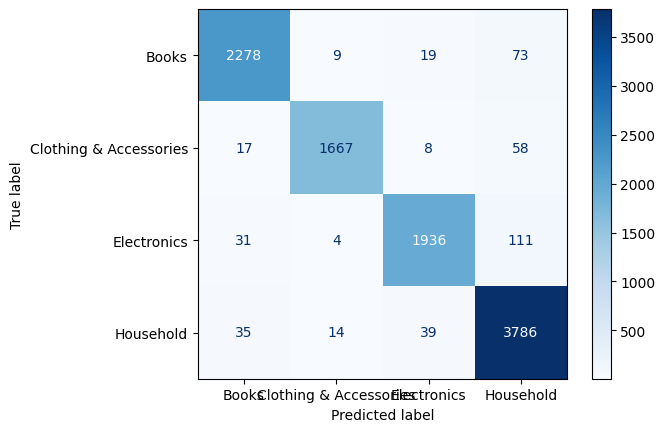

In [20]:
# 绘制混淆矩阵    Построение матрицы ошибок
y_pred = model.predict(X_test)  # 预测测试集的标签    Предсказание меток тестового набора данных
y_pred_classes = np.argmax(y_pred, axis=1)  # 获取预测结果的类别    Получение классов предсказанных результатов
cm = confusion_matrix(y_test, y_pred_classes)  # 计算混淆矩阵    Вычисление матрицы ошибок

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)  # 创建混淆矩阵显示对象    Создание объекта для отображения матрицы ошибок
disp.plot(cmap=plt.cm.Blues)  # 绘制混淆矩阵，并设置颜色映射    Построение матрицы ошибок с установкой цветовой схемы
plt.show()

In [21]:
# 定义文本分类函数    Определение функции классификации текста
def classify_text(text: str) -> tuple[str, dict[str, float]]:
    # Tokenize 输入文本    Токенизация входного текста
    tokenized = tokenize_texts([text], tokenizer, max_length)  # 对输入文本进行分词    Токенизация входного текста
    features = backbone(tokenized["input_ids"], attention_mask=tokenized["attention_mask"])  # 使用预训练模型提取特征    Извлечение признаков с использованием предобученной модели
    feature_vector = tf.reduce_mean(features.last_hidden_state, axis=1).numpy()  # 取最后隐藏层的均值作为特征向量    Использование среднего значения последнего скрытого слоя в качестве вектора признаков
    probabilities = model.predict(feature_vector)  # 预测类别概率    Предсказание вероятностей классов
    
    # 获取预测的类别    Получение предсказанного класса
    predicted_class = np.argmax(probabilities, axis=1)[0]  # 获取概率最高的类别索引    Получение индекса класса с наибольшей вероятностью
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]  # 将索引转换为类别标签    Преобразование индекса в метку класса

    # 概率转为字典格式 {类别名称: 概率}    Преобразование вероятностей в формат словаря {название класса: вероятность}
    label_probabilities = dict(zip(label_encoder.classes_, probabilities[0]))  # 将类别和对应的概率组成字典    Создание словаря с классами и их вероятностями

    return predicted_label, label_probabilities

In [30]:
test_text = [
    "华为MateBook GT 14 酷睿 Ultra笔记本电脑 115W超能释放 轻薄 商务学生办公全能本 官方旗舰",  # 华为笔记本电脑    Ноутбук Huawei
    "小米手环9 手环8升级 运动健康防水睡眠心率智能手环运动手环NFC全面屏长续航",  # 小米智能手环    Умный браслет Xiaomi
    "高等数学同济七版八版教材上下册同济高等数学第七版手写笔记辅导题集大一专升本考研同步辅导习题 配套张宇数学考研",  # 高等数学教材    Учебник по высшей математике
    "IKAE宜家电脑桌家用台式桌子工作台卧室简约现代简易书桌办公桌学",  # 宜家电脑桌    Компьютерный стол IKEA
    "安踏星芒丨革网拼接复古时尚老爹鞋女厚底增高休闲鞋百搭运动鞋",  # 安踏运动鞋    Спортивная обувь Anta
    "Higher Mathematics Tongji seventh edition eighth edition textbook up and down book Tongji higher mathematics seventh edition handwritten notes tutorial question set freshman college graduate exam synchronous tutorial exercises supporting Zhang Yu mathematics exams"  # 高等数学教材（英文）    Учебник по высшей математике (на английском)
]

In [31]:
# 测试分类函数    Тестирование функции классификации
for text in test_text:
    label, probabilities = classify_text(text)
    print(f"Text: {text}\n Classification result: {label}\n probabilities: {probabilities}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Text: 华为MateBook GT 14 酷睿 Ultra笔记本电脑 115W超能释放 轻薄 商务学生办公全能本 官方旗舰
 Classification result: Electronics
 probabilities: {'Books': 0.00058695255, 'Clothing & Accessories': 2.5329618e-09, 'Electronics': 0.9975673, 'Household': 0.0018457327}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Text: 小米手环9 手环8升级 运动健康防水睡眠心率智能手环运动手环NFC全面屏长续航
 Classification result: Electronics
 probabilities: {'Books': 0.00010999078, 'Clothing & Accessories': 0.066228755, 'Electronics': 0.9198632, 'Household': 0.013798034}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Text: 高等数学同济七版八版教材上下册同济高等数学第七版手写笔记辅导题集大一专升本考研同步辅导习题 配套张宇数学考研
 Classification result: Books
 probabilities: {'Books': 0.9511558, 'Clothing & Accessories': 4.6617524e-06, 'Electronics': 0.046222534, 'Household': 0.0026170928}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Text: IKAE宜家电脑桌家用台式桌子工作台卧室简约现代简易书桌办公桌学
 Classification result: Household
 probabilities: {'Books': 0.009271875, 'Clothing & Accessories': 6.8593785e-08, 'Electronics': 0.24366

# Bonus

In [32]:
# 分词并计算单词影响    Токенизация и вычисление влияния слов
def get_words_impact(text: str) -> list[tuple[str, dict[str, float]]]:
    # 使用 jieba 分词    Использование jieba для токенизации
    words = list(jieba.cut(text))  # 将文本分割成单词列表    Разделение текста на список слов
    original_label, original_probs = classify_text(text)  # 分类原始文本，获取标签和概率    Классификация исходного текста для получения метки и вероятностей
    impacts = []

    for i, word in enumerate(words):
        # 去掉当前词语    Удаление текущего слова
        modified_text = "".join(words[:i] + words[i+1:])  # 生成去掉当前词语后的文本    Создание текста без текущего слова
        _, modified_probs = classify_text(modified_text)  # 分类修改后的文本，获取概率    Классификация измененного текста для получения вероятностей

        # 计算每个类别的影响并以字典形式存储    Вычисление влияния для каждого класса и сохранение в виде словаря
        impact = {label: modified_probs[label] - original_probs[label] for label in original_probs.keys()}  # 计算影响    Вычисление влияния
        impacts.append((word, impact))  # 添加到影响列表    Добавление в список влияний

    return impacts

In [33]:
# 测试单词影响    Тестирование влияния слов
for text in test_text:
    impacts = get_words_impact(text)
    for word, impact in impacts:
        print(f"word: {word}\nimpact: {impact}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━